# Find my Star

### Imports

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from scipy.spatial import KDTree

## Testing

#### Functions

In [4]:
def viz_levels(image):
    cut_levels = pd.Series(image.flatten()).value_counts(bins=50).reset_index().set_axis(['value', 'count'], axis=1)
    cut_levels['value'] = [int(i.mid) for i in cut_levels['value']]
    cut_levels = cut_levels[cut_levels['value'] > 5]
    plt.bar(cut_levels['value'], cut_levels['count'], width=4, color='royalblue')
    return

In [5]:
def light_percent(image):
    all_coords = np.column_stack(np.where(image >= 0))
    grey_coords = np.column_stack(np.where(image > 0))
    print(f"the image is {np.round(grey_coords.size/all_coords.size*100, 2)}% light")

### Image Importing and exploring

In [6]:
# import reference image
ref_img = "data/reference/star_chart_ireland_2024-10-11_01-00.jpg"
ref_grey = cv2.imread(ref_img, flags=cv2.IMREAD_GRAYSCALE)
ref_grey.shape


(1111, 1111)

In [7]:
ref_grey = cv2.resize(ref_grey, dsize=(1000,1000))
ref_grey.shape


(1000, 1000)

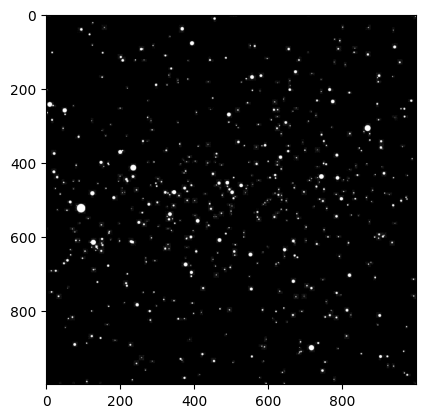

the image is 8.6% light


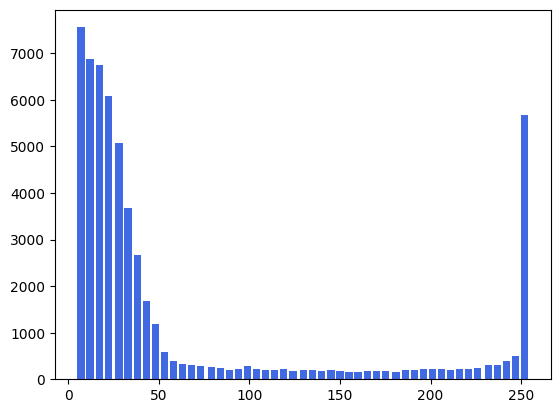

In [8]:
# get reference coords
plt.imshow(ref_grey, cmap="grey")
plt.show()
light_percent(ref_grey)
viz_levels(ref_grey)


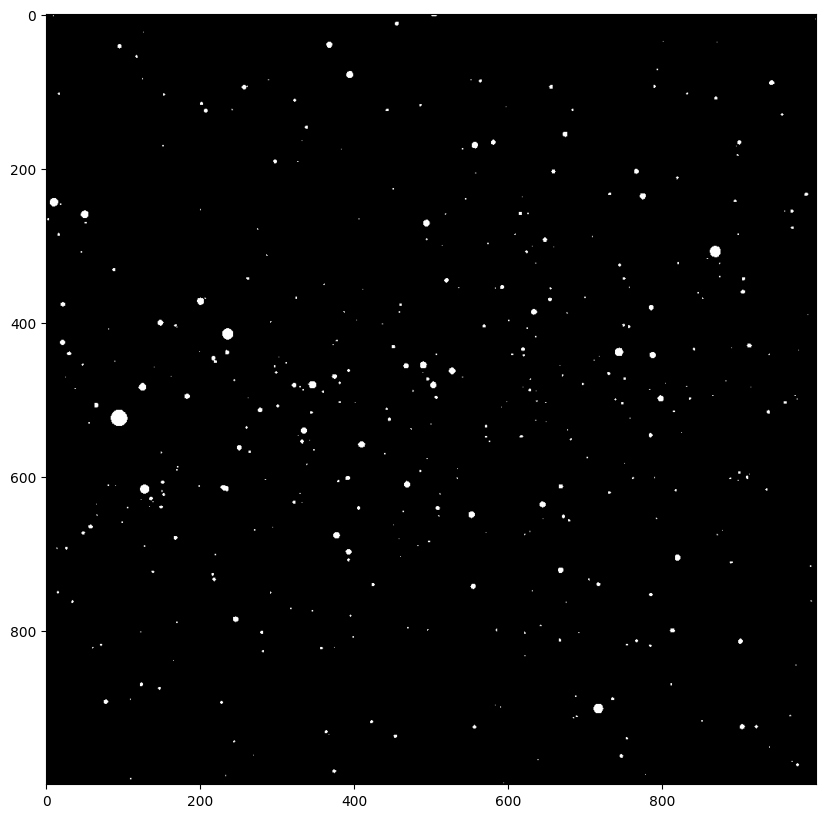

the image is 0.57% light


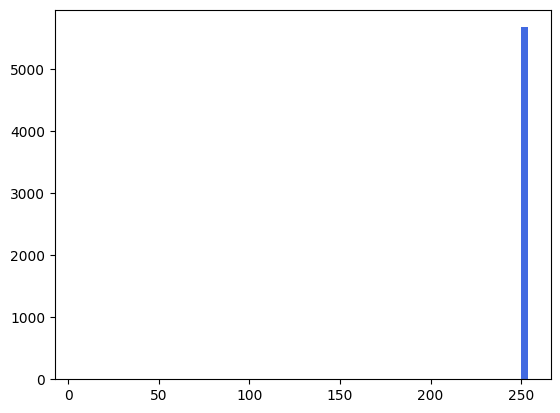

In [9]:
# remove all data below cutoff and visualize
hard_cut_ref = ref_grey.copy()
hard_cut_ref[hard_cut_ref<250] = 0

plt.subplots(figsize=(10,10))
plt.imshow(hard_cut_ref, cmap="grey")
plt.show()
light_percent(hard_cut_ref)
viz_levels(hard_cut_ref)


In [10]:
# import test image no. 1
test_img = "data/testing/astro1.jpeg"
test_grey = cv2.imread(test_img, flags=cv2.IMREAD_GRAYSCALE)
test_grey = test_grey[:min(test_grey.shape), :min(test_grey.shape)]
test_grey = cv2.resize(test_grey, dsize=(1000,1000))
test_grey.shape

(1000, 1000)

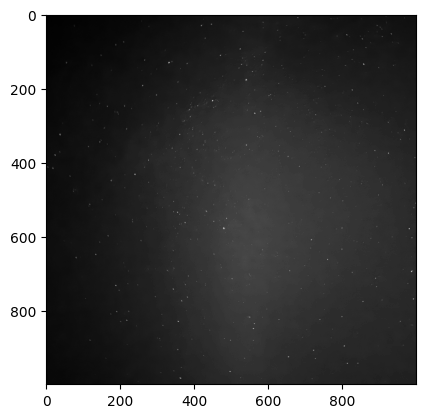

the image is 100.0% light


In [11]:
plt.imshow(test_grey, cmap="grey")
plt.show()
light_percent(test_grey)

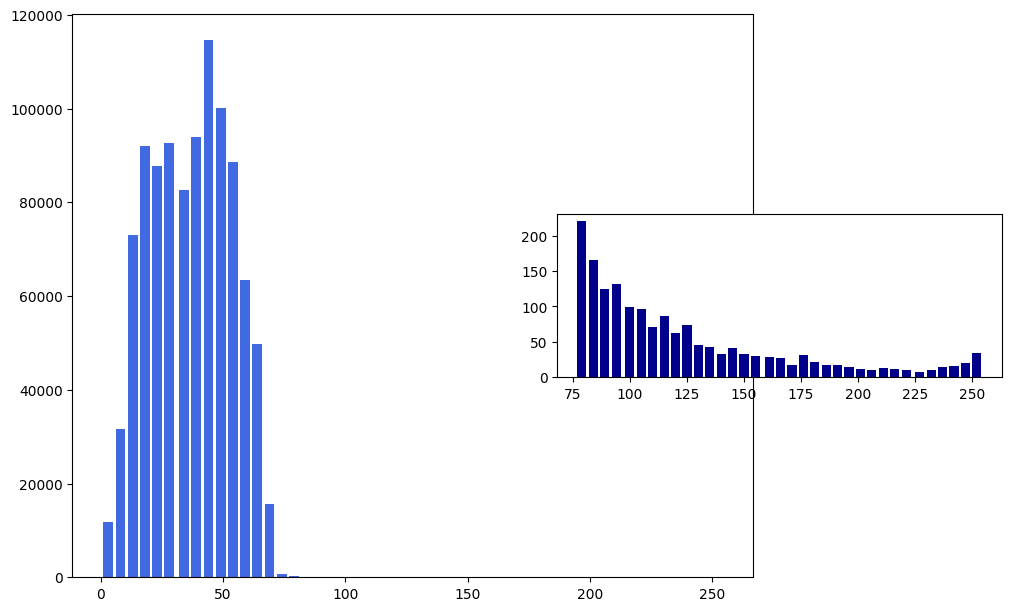

In [12]:
# visulize noise cutoff
test_levels = pd.Series(test_grey.flatten()).value_counts(bins=50).reset_index().set_axis(['value', 'count'], axis=1)
test_levels['value'] = [int(i.mid) for i in test_levels['value']]
high_test_levels = test_levels[test_levels['value'] >= 77]

fig = plt.figure(constrained_layout=True, figsize=(10,6))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[:, 0:3])
ax2 = fig.add_subplot(gs[1, 2:4])

ax1.bar(test_levels['value'], test_levels['count'], width=4, color='royalblue')
ax2.bar(high_test_levels['value'], high_test_levels['count'], width=4, color='darkblue')
plt.show()


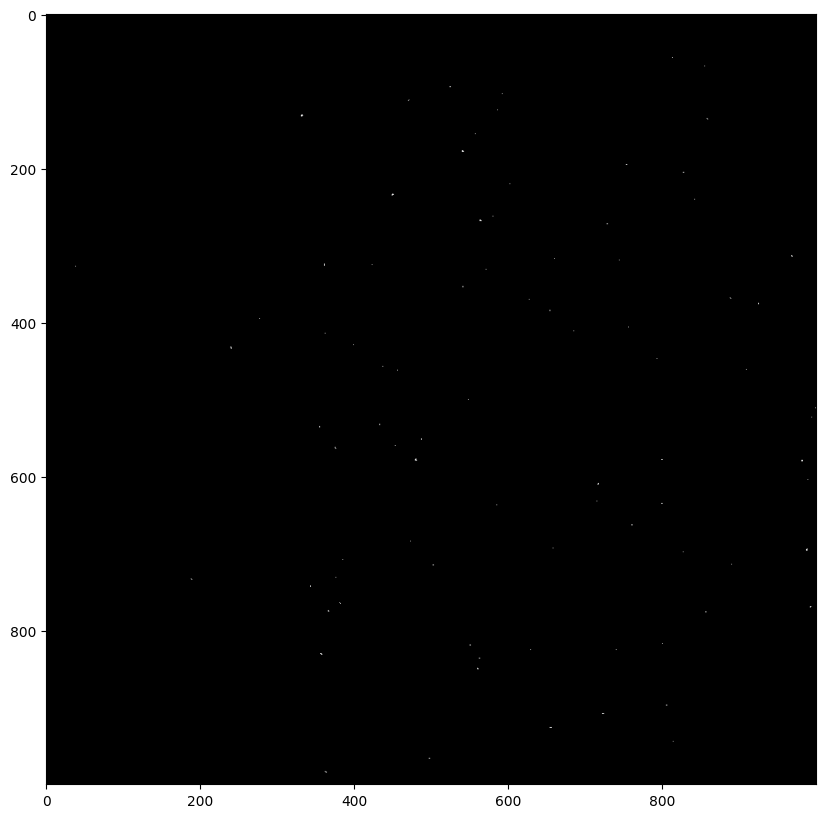

the image is 0.02% light


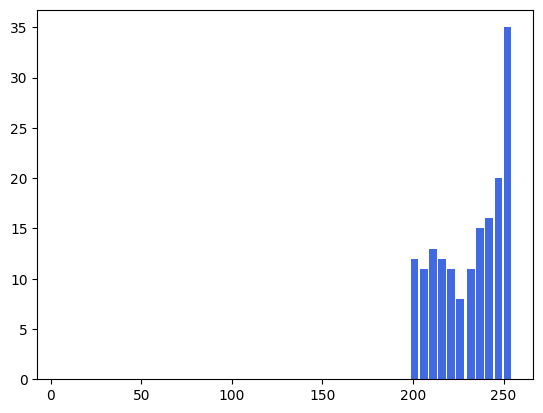

In [13]:
# remove all data below cutoff and visualize
hard_cut_test = test_grey.copy()
hard_cut_test[hard_cut_test<200] = 0
plt.subplots(figsize=(10,10))
plt.imshow(hard_cut_test, cmap="grey")
plt.show()
light_percent(hard_cut_test)
viz_levels(hard_cut_test)

### Image Transformation

In [14]:
# transform to binary maps
_, ref_bi = cv2.threshold(hard_cut_ref, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, test_bi = cv2.threshold(hard_cut_test, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ref_bi.shape, test_bi.shape

((1000, 1000), (1000, 1000))

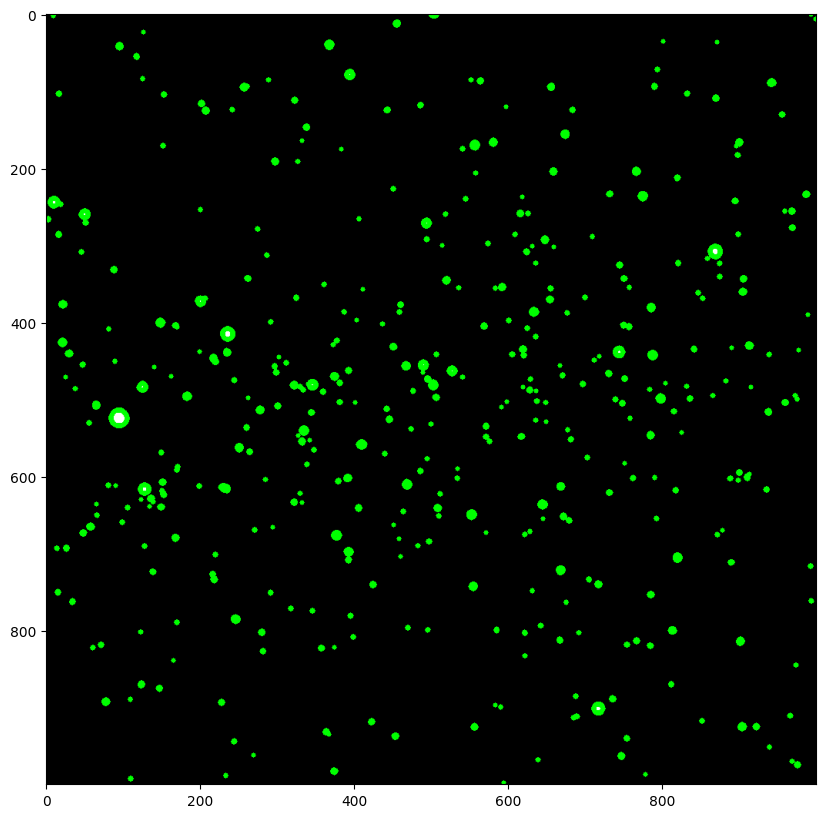

reference: [[594], [998]], (len=406)


In [15]:
# find contours
ref_color = cv2.cvtColor(hard_cut_ref, cv2.COLOR_GRAY2RGB)
ref_cont, _ = cv2.findContours(ref_bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(ref_color, ref_cont, -1, (0,255,0), 5)
plt.subplots(figsize=(10,10))
plt.imshow(ref_color)
plt.show()

ref_contours = [[[pt[0][0] for pt in cont],[pt[0][1] for pt in cont]] for cont in ref_cont]
print(f'reference: {ref_contours[0]}, (len={len(ref_contours)})')


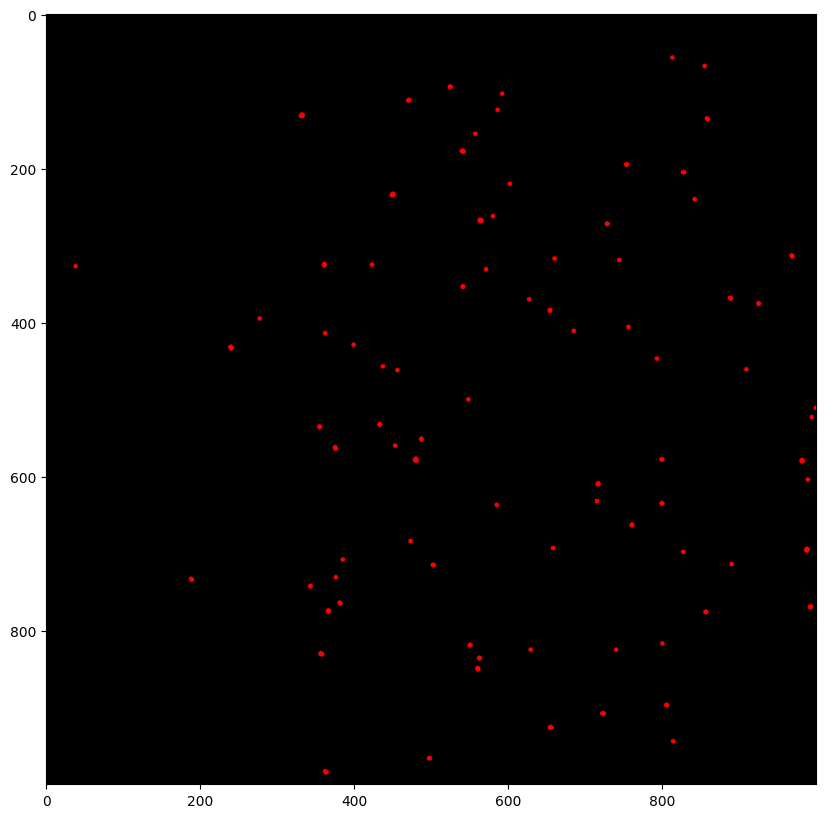

test: [[362, 363, 364, 363], [983, 984, 984, 984]], (len=84)


In [16]:
test_color = cv2.cvtColor(hard_cut_test, cv2.COLOR_GRAY2RGB)
test_cont, _ = cv2.findContours(test_bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_color, test_cont, -1, (255,0,0), 5)
plt.subplots(figsize=(10,10))
plt.imshow(test_color)
plt.show()

test_contours = [[[pt[0][0] for pt in cont],[pt[0][1] for pt in cont]] for cont in test_cont]
print(f'test: {test_contours[0]}, (len={len(test_contours)})')


In [17]:
# i = 0
# for cont in ref_contours:
#     xs = cont[0]
#     ys = cont[1]
#     plt.plot(xs, ys, 'sb', mfc='xkcd:sky blue', markersize=300/len(cont[0]))

#     xroll = np.roll(xs,1)
#     yroll = np.roll(ys,1)
#     poly_area = np.abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2
#     if poly_area == 0:
#         avg_x = np.mean(xs)
#         avg_y = np.mean(ys)
#         print(avg_x, avg_y)
#         plt.plot([avg_x], [avg_y], 'or', label='average')
#     else:
#         Cx = np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6*poly_area)
#         Cy = np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6*poly_area)
#         print(Cx, Cy)
#         plt.plot([Cx], [Cy], 'og', label='centroid')

#     xs = cont[0] + [cont[0][0]]
#     ys = cont[1] + [cont[1][0]]
#     plt.plot(xs, ys, '-p')

#     plt.legend()
#     plt.margins(0.5, 0.5)
#     plt.show()
#     i+= 1
#     if i == 10:
#         break

In [18]:
def get_centroids(contours):
    cxs = []
    cys = []

    for cont in contours:
        xs = cont[0]
        ys = cont[1]

        xroll = np.roll(xs,1)
        yroll = np.roll(ys,1)
        poly_area = np.abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2
        if poly_area == 0:
            cx = np.round(np.mean(xs), 2)
            cy = np.round(np.mean(ys), 2)
        else:
            cx = np.round(np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)
            cy = np.round(np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)

        cxs.append(cx)
        cys.append(cy)

    return [cxs, cys]

reference centroids: 406


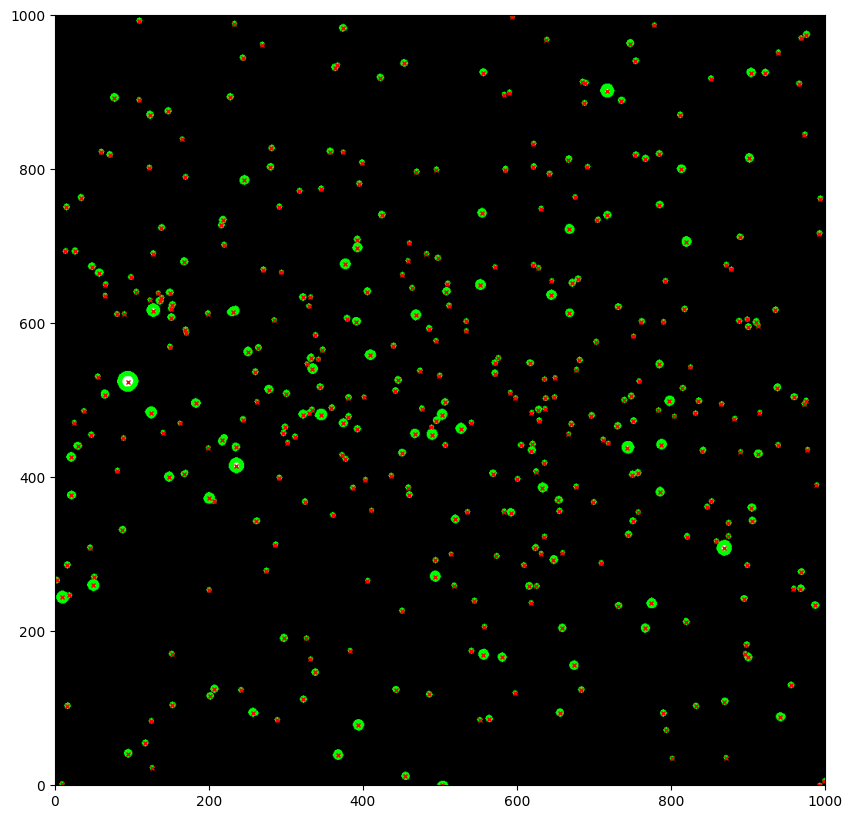

In [19]:
ref_cent_x, ref_cent_y = get_centroids(ref_contours)
print(f'reference centroids: {len(ref_cent_x)}')
plt.subplots(figsize=(10,10))
plt.imshow(ref_color)
plt.plot(ref_cent_x, ref_cent_y, 'xr', markersize=3)
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

reference centroids: 84


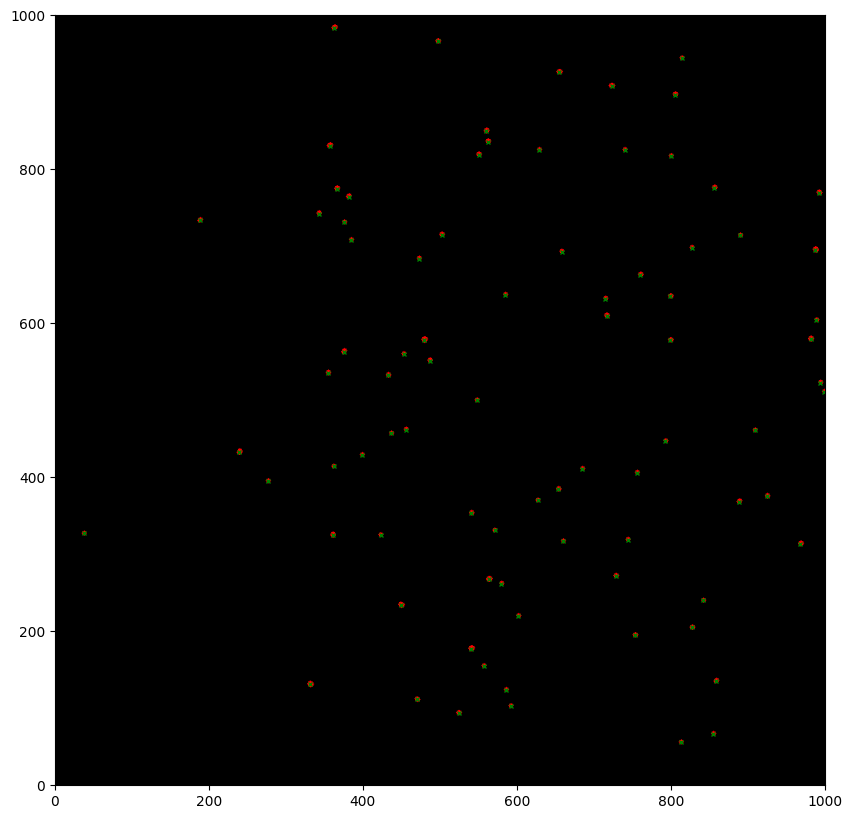

In [ ]:
test_cent_x, test_cent_y = get_centroids(test_contours)
print(f'reference centroids: {len(test_cent_x)}')
plt.subplots(figsize=(10,10))
plt.imshow(test_color)
plt.plot(test_cent_x, test_cent_y, 'xg', markersize=3)
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

In [662]:
 # start with 1, calc 2 nearest neighbors, get angles,
    # take off 1st, get third nearest to no.2&3, get angles
    # repeat
    # last two, add 1st pt, get angles

# def get_triangles(centroids):

def update_counts(star_counts, fin_stars, n_pts):
    for n_pt in n_pts:
        if star_counts[n_pt] == 0:
            continue
        else:
            star_counts[n_pt] -= 1
        if star_counts[n_pt] == 0:
            fin_stars.add(n_pt)


centroids = list(zip(ref_cent_x, ref_cent_y))
star_tree = KDTree(centroids)

star_counts = [6 for r in range(len(centroids))]
fin_stars = set([])

_, first_idxs = star_tree.query((500,500), k=1)
triangles = []

triangle = [centroids[first_idxs]]
tri_ids = [first_idxs]

b = 0
while b < 1:

    k = 6
    while len(triangle) < 3:
        dists, sidxs = star_tree.query([triangle[0]], k=k)
        try:
            n_pts = [x for x in sidxs[0][1:] if x not in fin_stars and star_counts[x] > 0]
            print('n_pts', n_pts)
            points = [centroids[n_pt] for n_pt in n_pts]
            print(points)
            if len(n_pts) > 1:
                idxs = [np.where(sidxs == n_pt) for n_pt in n_pts]
                dists = [dists[i] for i in idxs]
                s_dists = [sum(dists[0]), sum(dists[1])]
                n_pt = n_pts[s_dists.index(min(s_dists))]
            else:
                n_pt = n_pts[0]
            triangle.append(centroids[n_pt])
            tri_ids.append(n_pt)

        except IndexError:
            print('Index error:')
            print('sidxs', sidxs)
            print('star_counts', star_counts)
            break

        k += 1

    triangles.append(triangle)
    update_counts(star_counts, fin_stars, tri_ids)

    triangle = [triangle[1]]
    tri_ids = [tri_ids[1]]

    print('')

    b += 1


n_pts [224, 231, 211, 178, 238]
[(502.52, 481.28), (495.35, 473.5), (476.33, 489.0), (499.5, 532.0), (489.0, 465.0)]
n_pts [224, 231, 211, 178, 238, 241]
[(502.52, 481.28), (495.35, 473.5), (476.33, 489.0), (499.5, 532.0), (489.0, 465.0), (526.97, 462.97)]



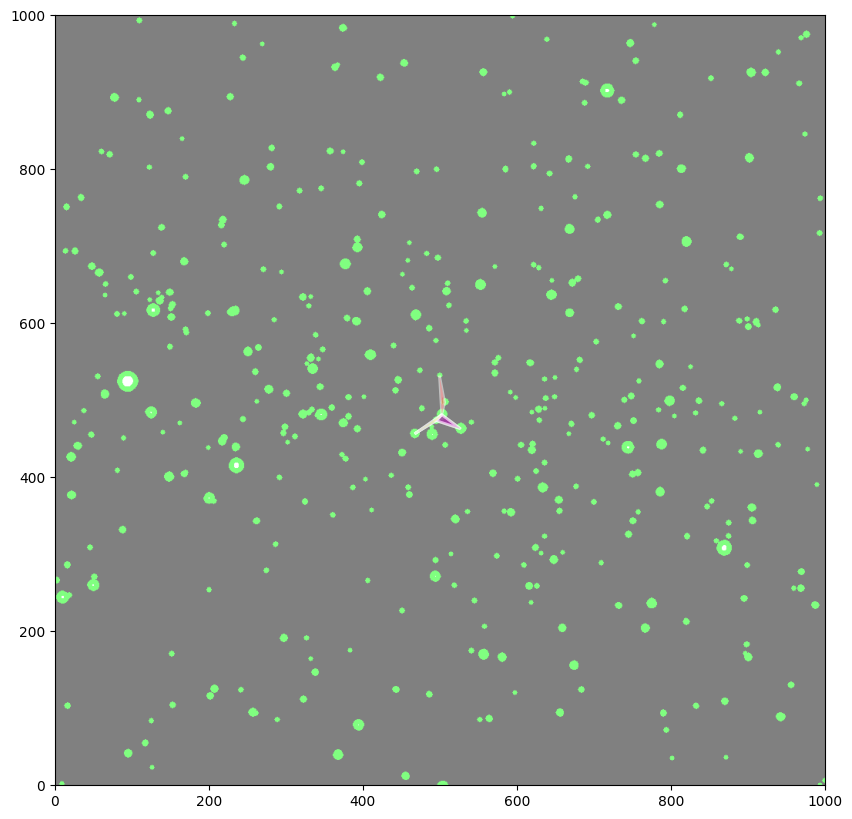

In [640]:
trixs, triys = zip(*triangles[0])
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ref_color, alpha=0.5)
colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'cyan']
c = 0
for tri in triangles:
    ax.add_patch(Polygon(tri, alpha=0.5, edgecolor='white', facecolor=colors[c], linewidth=2))
    if c < len(colors) - 1:
        c += 1
    else:
        c = 0
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

### Ideas for future implememtation

- automatic cutoff finder for noise gate